In [1]:
#https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb
from xlib.astock import AStock
import talib as ta
import numpy as np 
import pandas as pd
import mplfinance as mpf


def getdata(ts_code,df_cal,start_date,end_date):
    data=AStock.getStockDailyPriceByCode(ts_code,'tushare')
    if not df_cal.empty:
        data=pd.merge(df_cal,data,on=['trade_date'],how='outer', validate="one_to_many")
    data=data[data['trade_date']>=start_date]
    data=data[data['trade_date']<=end_date]
    data['score']=0
    data['ts_code']=ts_code
    data=data.fillna(method='ffill')        
    data['date'] = data['trade_date'] 
    data['trade_date'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
    data=data.set_index('trade_date')   
    
    
    
    data["macd"], data["macd_signal"], data["macd_hist"] = ta.MACD(data['close'])
    data['macd_hist_1']= data['macd_hist'].shift(1)
    data['gold']=data.apply(lambda x: 1 if x['macd_hist_1']<=0 and x['macd_hist']>0   else 0, axis = 1)
    data['death']=data.apply(lambda x: 1 if x['macd_hist_1']>=0 and x['macd_hist']<0   else 0, axis = 1)
    data['high_signal']=np.nan
    data['low_signal']=np.nan
    

    max_value=0
    min_value=9999
    max_idx=0
    min_idx=0
    last_max=0
    last_min=9999
    data.sort_index()
    for index, row in data.iterrows():   
        if row['close']>max_value:
            max_value=row['close']
            max_idx=index

        elif row['close']<min_value:
            min_value=row['close']
            min_idx=index

        elif row['gold']==1 or row['death']==1:
            data.at[max_idx,'high_signal']=max_value*1.1
            data.at[min_idx,'low_signal']=min_value*0.9
            max_value=0
            min_value=9999      


    #清理连续重复的点，在一个循环里也可以搞定，单开一个循环逻辑更清晰
    flag="none"
    high_value=0
    high_index=0
    low_value=9999
    low_index=0
    for index, row in data.iterrows():
        if  row['high_signal']>0 and row['low_signal']>0:
            data.at[index,'high_signal']=np.nan
            data.at[index,'low_signal']=np.nan

        if row['high_signal']>0 or row['low_signal']>0:
            if(flag=="none"):
                if not pd.isna(row['high_signal']):
                    flag="high"
                    high_value=row['close']
                    high_index=index
                else:
                    flag="low"
                    low_value=row['close']
                    low_index=index
            elif(flag=="high"):
                #如果上一个标记是high，且这个标记还是high
                if row['high_signal']>0:
                    #如果现在的收盘价比上一个高点还高，那么清除掉上一个标记
                    if(row['close']>high_value):
                        data.at[high_index,'high_signal']=np.nan
                        high_value=row['high_signal']
                        high_index=index
                    else:
                        data.at[index,'high_signal']=np.nan
                else:
                    flag="low"
                    low_value=row['low_signal'] 
                    low_index=index


            elif(flag=="low"):
                #如果上一个标记是low，且这个标记还是low
                if not pd.isna(row['low_signal']):
                    #如果现在的收盘价比上一个低点还低，那么清除掉上一个标记
                    if(row['close']<low_value):
                        data.at[low_index,'low_signal']=np.nan
                        low_value=row['low_signal']
                        low_index=index

                    else:
                        data.at[index,'low_signal']=np.nan
                else:
                    flag="high"
                    high_value=row['high_signal'] 
                    high_index=index        

            else:
                pass
    return data



In [107]:
def dow_signal(df,date,draw=True):
    #date = pd.to_datetime(date, format='%Y%m%d')
    data['linear_low']=np.nan
    data['linear_high']=np.nan
    
    df2=df.loc[:date]
    #df2=df2.dropna(subset=['close'])
 

    df3=df2[(df2.gold==1)|(df2.death==1)]
    
    if df3.empty:
        #print("没有信号")
        df2['high_signal']=np.nan
        df2['low_signal']=np.nan
        return 0
    
    first_point=df3.copy().iloc[0].name
    last_point=df3.copy().iloc[-1].name

    df3=df2.copy()
    df3.loc[last_point:,('high_signal','low_signal')]=np.nan
    
    df4=df3.copy()
    df4.loc[:first_point,('high_signal','low_signal')]=np.nan

    now=df4.iloc[-1]
    signal=df4.copy()[(df4.high_signal>0)|(df4.low_signal>0)]

    if signal.empty or len(signal)<6:
        #print("没有信号")
        return 0
    
    signal['signal']=signal.apply(lambda x:'high' if x['high_signal']>0 else 'low',axis=1)
    alines=[]
    
    
    
    
    #print(signal)
    
    now_close=now['close']
    #print("今日收盘价："+str(now_close))
    
    if(signal.iloc[-1]['signal']=='low'):
        low3=signal.iloc[-1]['close']
        low2=signal.iloc[-3]['close']
        low1=signal.iloc[-5]['close']
        high3=signal.iloc[-2]['close']
        high2=signal.iloc[-4]['close']
        high1=signal.iloc[-6]['close']
    else:
        low3=signal.iloc[-2]['close']
        low2=signal.iloc[-4]['close']
        low1=signal.iloc[-6]['close']    
        high3=signal.iloc[-1]['close']
        high2=signal.iloc[-3]['close']
        high1=signal.iloc[-5]['close']
    
    
    if(signal.iloc[-1]['signal']=='low'):
        data.at[signal.iloc[-1].name,'linear_low']=signal.iloc[-1]['close']
        data.at[signal.iloc[-3].name,'linear_low']=signal.iloc[-3]['close']
        data.at[signal.iloc[-5].name,'linear_low']=signal.iloc[-5]['close']
        data.at[signal.iloc[-2].name,'linear_high']=signal.iloc[-2]['close']
        data.at[signal.iloc[-4].name,'linear_high']=signal.iloc[-4]['close']
        data.at[signal.iloc[-6].name,'linear_high']=signal.iloc[-6]['close']    
    else:
        data.at[signal.iloc[-2].name,'linear_low']=signal.iloc[-2]['close']
        data.at[signal.iloc[-4].name,'linear_low']=signal.iloc[-4]['close']
        data.at[signal.iloc[-6].name,'linear_low']=signal.iloc[-6]['close']
        data.at[signal.iloc[-1].name,'linear_high']=signal.iloc[-1]['close']
        data.at[signal.iloc[-3].name,'linear_high']=signal.iloc[-3]['close']
        data.at[signal.iloc[-5].name,'linear_high']=signal.iloc[-5]['close']  
        
        
    linear_high=data['linear_high'].loc[signal.iloc[-6].name:date]
    linear_high=linear_high.interpolate()    
    linear_low=data['linear_low'].loc[signal.iloc[-6].name:date]
    linear_low=linear_low.interpolate()
    score=0
    if(low3>low2 and low2>low1):
        #print("\n----上升趋势中---")
        #print("123法则")
        hlines=dict(hlines=[low3],linestyle='-.',colors=['y'],linewidths=0.5)
        data['tend']=linear_low    
        
        #法则1，趋势线被突破，发生反转几率大
        #print("当前价格："+str(round(now_close,2))+"，趋势线点位："+str(round(linear_low[-1],2)))    
        if(len(linear_low)>0):
            if(now_close>linear_low[-1]):
                #print("当前价格在趋势线之上，大概率维持上升趋势，+1分")
                score=score+1
            else:
                #print("当前价格在趋势线之下，趋势变弱，-1分")
                score=score-1
        
        #法则2，上升趋势不再创新高
        if(high3>high2 or (now_close>high3) and now_close>high2):
            #print("当前价格逐步保持新高状态，大概率维持上升趋势，+1分")
            score=score+1
        else:
            score=score-1
            #print("当前价格趋势不再新高，上升趋势变弱，-1分")            
            
        #法则3，上升趋势不再创新高
        if(now_close>low3):
            #print("当前价格在前期低点之上，大概率维持上升趋势，+1分")
            score=score+1
        else:
            score=score-1
            #print("当前价格在前期低点之下，趋势变弱，-1分")   
            
        #print("2B法则")
        if(high3>high2 and now_close<high3):
            score=score-1
            #print("穿越前高后发生跌破前高现象，趋势可能转变，-1分")   
        else:
            score=score+1
            #print("当前未发生穿越前高或跌破前高现象，大概率维持上升趋势，+1分") 
        
    elif(low3<low2 and low2<low1):
        #print("\n----下降趋势中---")
        hlines=dict(hlines=[high3],linestyle='-.',colors=['y'],linewidths=0.5)
        data['tend']=linear_high      

        #print("123法则")  
        
        #法则1，趋势线被突破，发生反转几率大
        #print("当前价格："+str(round(now_close,2))+"，趋势线点位："+str(round(linear_low[-1],2)))    
        if(len(linear_high)>0):
            if(now_close>linear_high[-1]):
                score=score+1
                #print("当前价格在趋势线之上，有概率发生反转，+1分")
            else:
                score=score-1
                #print("当前价格在趋势线之下，维持下行趋势，-1分")
        
        #法则2，下降趋势不再创新低
        if(now_close>low3):
            score=score+1
            #print("当前暂未破新低，可持续观察，+1分")
        else:
            score=score-1
            #print("又新低了，快逃！-1分")            
            
        #法则3，下降趋势中突破前高
        if(now_close>high3):
            score=score+1
            #print("破前高，+1分")
        else:
            score=score-1
            #print("没破前高，-1分")   
            
        #print("2B法则")
        if(low3<low2 and now_close>low2):
            score=score+1
            #print("新低后涨回前低，可能会反转，+1分")           
        else:
            score=score-1
            #print("当前未发生新低后涨回前低现象，大概率维持下降趋势，-1分")         
        
    else:
        #print("\n----震荡趋势中---")
        #print("看不出来啥")
        data['tend']=np.nan
        data.at[data.iloc[0].name,'tend']=0
    
    #df.at[date,'score']=score
    return score
    #return df

In [129]:
from xlib.mysql import mysql
import tushare as ts
db="tushare"
start_date='20180101'
end_date='20220401'
df_cal=mysql.selectToDf("select cal_date as trade_date from astock_trade_cal where is_open=1",db)
ts_code='002624.sz'
start_date='20180101'
end_date='20220401'


data=getdata(ts_code,df_cal,start_date,end_date)

df=dow_signal(data,'20180506')
#df[40:50]

for date in data.index.tolist()[100:150]:
    print(str(date)+','+str(dow_signal(data,date)))
#data



2018-06-04 00:00:00,0
2018-06-05 00:00:00,0
2018-06-06 00:00:00,0
2018-06-07 00:00:00,0
2018-06-08 00:00:00,0
2018-06-11 00:00:00,0
2018-06-12 00:00:00,0
2018-06-13 00:00:00,0
2018-06-14 00:00:00,0
2018-06-15 00:00:00,0
2018-06-19 00:00:00,0
2018-06-20 00:00:00,0
2018-06-21 00:00:00,0
2018-06-22 00:00:00,0
2018-06-25 00:00:00,0
2018-06-26 00:00:00,0
2018-06-27 00:00:00,0
2018-06-28 00:00:00,0
2018-06-29 00:00:00,0
2018-07-02 00:00:00,0
2018-07-03 00:00:00,0
2018-07-04 00:00:00,0
2018-07-05 00:00:00,0
2018-07-06 00:00:00,0
2018-07-09 00:00:00,0
2018-07-10 00:00:00,0
2018-07-11 00:00:00,0
2018-07-12 00:00:00,0
2018-07-13 00:00:00,0
2018-07-16 00:00:00,0
2018-07-17 00:00:00,0
2018-07-18 00:00:00,0
2018-07-19 00:00:00,-2
2018-07-20 00:00:00,-2
2018-07-23 00:00:00,0
2018-07-24 00:00:00,0
2018-07-25 00:00:00,0
2018-07-26 00:00:00,0
2018-07-27 00:00:00,-2
2018-07-30 00:00:00,-2
2018-07-31 00:00:00,-2
2018-08-01 00:00:00,-2
2018-08-02 00:00:00,-2
2018-08-03 00:00:00,-2
2018-08-06 00:00:00,-2
2

In [119]:
import datetime
import operator
from xlib.mysql import mysql
import tushare as ts
db="tushare"
start_date='20180101'
end_date='20220401'
df_cal=mysql.selectToDf("select cal_date as trade_date from astock_trade_cal where is_open=1",db)
ts_code='002624.sz'
start_date='20180101'
end_date='20220401'


data=getdata(ts_code,df_cal,start_date,end_date)


begin = datetime.date(2018,1,1)
end = datetime.date(2022,4,1)
d = begin
delta = datetime.timedelta(days=1)
while d <= end:
    d += delta
    end_date=d.strftime("%Y%m%d")
    data2=getdata(ts_code,df_cal,start_date,end_date)
    end_idx=pd.to_datetime(end_date, format='%Y%m%d')
    if end_idx in data.index.values and end_idx in data2.index.values:
        
        dow1=dow_signal(data,date)
        dow2=dow_signal(data2,date)
        
        #之前返回的是df，现在返回的是score，当前这段代码暂时不能运行，如需运行，需将dow_signal函数由return score改成return df，
        
        list1=dow1.loc[end_idx].to_list()
        list2=dow1.loc[end_idx].to_list()
        print(end_date+","+str(str(list1)==str(list2)))
        if str(list1)!=str(list2):
#             print(data.loc[end_idx])
#             print(data2.loc[end_idx])
            print(data)
            print(data2)
            data.to_csv("./xlib/cache/data_"+end_date+".csv")
            data2.to_csv("./xlib/cache/data2_"+end_date+".csv")
            
            print(list(set(list1) ^ set(list2)))

AttributeError: 'int' object has no attribute 'loc'

In [133]:
import datetime
import operator
from xlib.mysql import mysql
import tushare as ts
db="tushare"
start_date='20180101'
end_date='20220401'
df_cal=mysql.selectToDf("select cal_date as trade_date from astock_trade_cal where is_open=1",db)
ts_code='002624.sz'
start_date='20180101'
end_date='20220401'
data=getdata(ts_code,df_cal,start_date,end_date)
begin = datetime.date(2018,9,1)
end = datetime.date(2018,12,1)
d = begin
delta = datetime.timedelta(days=1)
while d <= end:
    d += delta
    end_date=d.strftime("%Y%m%d")
    data2=getdata(ts_code,df_cal,start_date,end_date)
    end_idx=pd.to_datetime(end_date, format='%Y%m%d')
    if end_idx in data.index.values and end_idx in data2.index.values:
        dow1=dow_signal(data.copy(),end_date)
        dow2=dow_signal(data2.copy(),end_date)
        #print(end_date+"_"+str(dow1)+","+str(dow2))
        if str(dow1)!=str(dow2):
            print(end_date+"_"+str(dow1)+","+str(dow2))
            data.to_csv("./xlib/cache/data_"+end_date+".csv")
            data2.to_csv("./xlib/cache/data2_"+end_date+".csv")

In [109]:
from xlib.mysql import mysql
import tushare as ts
db="tushare"
start_date='20180101'
end_date='20220401'
df_cal=mysql.selectToDf("select cal_date as trade_date from astock_trade_cal where is_open=1",db)
basic=mysql.selectToDf("select ts_code,industry from astock_basic",db)

pro = ts.pro_api()
df_code = pro.index_weight(index_code='000300.SH', start_date=start_date, end_date=end_date)
df_code.drop_duplicates(subset=['con_code'],keep='first',inplace=True)
 
df_all=[]
df_mean_all=[]
df_code=df_code['con_code'].to_list()


for ts_code in df_code:
    df=getdata(ts_code,df_cal,start_date,end_date)
    for date in df.index.tolist():
#         print(df)
#         print(date)
        try:
            df.at[date,'score']=dow_signal(df,date)
        except:
            pass
    
    
    df_all.append(df)
    print(ts_code)

df_all=pd.concat(df_all)
df_all.to_csv("./xlib/cache/fin40.csv")
df_all

603195.SH
003816.SZ
300782.SZ
601138.SH
600989.SH
601698.SH
300750.SZ
601916.SH
002938.SZ
601319.SH
603259.SH
601236.SH
300896.SZ
601865.SH
601066.SH
300759.SZ
300760.SZ
688111.SH
601990.SH
603486.SH
002916.SZ
603392.SH
600025.SH
603659.SH
603087.SH
300677.SZ
603882.SH
603260.SH
001979.SZ
300676.SZ
603233.SH
601155.SH
300628.SZ
601108.SH
300498.SZ
300595.SZ
300601.SZ
603501.SH
002841.SZ
603833.SH
603517.SH
601881.SH
300408.SZ
300413.SZ
300558.SZ
300450.SZ
603019.SH
603658.SH
002812.SZ
603939.SH
603338.SH
601966.SH
603799.SH
300433.SZ
002821.SZ
603160.SH
603986.SH
601985.SH
300529.SZ
002791.SZ
601021.SH
603369.SH
603899.SH
000333.SZ
601808.SH
601939.SH
002179.SZ
601169.SH
603806.SH
002714.SZ
002709.SZ
601238.SH
603288.SH
603993.SH
300347.SZ
300316.SZ
601231.SH
601360.SH
002157.SZ
601800.SH
601225.SH
601100.SH
300274.SZ
601669.SH
002624.SZ
002602.SZ
002607.SZ
002600.SZ
002601.SZ
002594.SZ
002568.SZ
601216.SH
002555.SZ
601799.SH
601933.SH
601211.SH
002736.SZ
000166.SZ
300144.SZ
600919.SH


,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,...,score,date,macd,macd_signal,macd_hist,macd_hist_1,gold,death,high_signal,low_signal
trade_date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180102,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2018-01-03,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180103,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2018-01-04,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180104,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2018-01-05,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180105,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2018-01-08,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180108,NaN,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28,600340.SH,3.879841,4.099832,3.759846,4.099832,3.729847,0.369985,9.9196,2574441.53,1039357.120,...,4,20220328,0.123719,-0.009139,0.132858,0.102445,0,0,NaN,NaN
2022-03-29,600340.SH,4.099832,4.149830,3.689849,3.689849,4.099832,-0.409983,-10.0000,4050496.88,1588309.715,...,0,20220329,0.139454,0.020580,0.118874,0.132858,0,0,NaN,NaN
2022-03-30,600340.SH,3.599853,3.949838,3.519856,3.729847,3.689849,0.039998,1.0840,3197617.33,1204803.061,...,0,20220330,0.153383,0.047140,0.106243,0.118874,0,0,NaN,NaN


In [110]:
df_all=pd.read_csv('./xlib/cache/fin40.csv',index_col=0)
#df=df.reset_index(drop=True)
df_all

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,...,score,date,macd,macd_signal,macd_hist,macd_hist_1,gold,death,high_signal,low_signal
trade_date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180102,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2018-01-03,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180103,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2018-01-04,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180104,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2018-01-05,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180105,NaN,NaN,NaN,NaN,0,0,NaN,NaN
2018-01-08,603195.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,20180108,NaN,NaN,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28,600340.SH,3.879841,4.099832,3.759846,4.099832,3.729847,0.369985,9.9196,2574441.53,1039357.120,...,4,20220328,0.123719,-0.009139,0.132858,0.102445,0,0,NaN,NaN
2022-03-29,600340.SH,4.099832,4.149830,3.689849,3.689849,4.099832,-0.409983,-10.0000,4050496.88,1588309.715,...,0,20220329,0.139454,0.020580,0.118874,0.132858,0,0,NaN,NaN
2022-03-30,600340.SH,3.599853,3.949838,3.519856,3.729847,3.689849,0.039998,1.0840,3197617.33,1204803.061,...,0,20220330,0.153383,0.047140,0.106243,0.118874,0,0,NaN,NaN


In [111]:
df_all=pd.read_csv('./xlib/cache/fin40.csv',index_col=0)
df_all['date']=df_all.index
df_all['rank']=df_all.groupby('date')['score'].rank(method='max',ascending=False)
df_all['signal']=df_all.apply(lambda x: 1 if x['score']>=3 else 0 ,axis=1)
df_all.rename(columns={'ts_code':'symbol'}, inplace = True)
df_all[df_all.score!=0]

,symbol,open,high,low,close,pre_close,change,pct_chg,vol,amount,...,macd,macd_signal,macd_hist,macd_hist_1,gold,death,high_signal,low_signal,rank,signal
trade_date,,,,,,,,,,,,,,,,,,,,,
2020-10-12,603195.SH,151.369186,154.337209,151.369186,154.337209,150.567820,3.769390,2.5034,16016.73,247406.148,...,-1.634155,-1.684478,0.050323,-0.275199,1,0,NaN,NaN,122.0,0
2020-10-13,603195.SH,154.337209,162.825756,154.337209,161.420891,154.337209,7.083682,4.5897,25382.66,410266.071,...,-0.785557,-1.504694,0.719137,0.050323,0,0,NaN,NaN,114.0,0
2020-10-14,603195.SH,161.747374,168.187984,161.747374,166.219196,161.420891,4.798304,2.9725,28193.45,473708.263,...,0.271022,-1.149551,1.420573,0.719137,0,0,NaN,NaN,34.0,1
2020-10-15,603195.SH,166.209302,167.920862,164.240514,165.348576,166.219196,-0.870620,-0.5238,13905.12,233576.496,...,1.026286,-0.714383,1.740670,1.420573,0,0,NaN,NaN,107.0,0
2020-10-16,603195.SH,165.952074,169.375194,163.735950,165.219961,165.348576,-0.128614,-0.0778,13796.83,231962.141,...,1.596062,-0.252294,1.848357,1.740670,0,0,NaN,NaN,105.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-17,600340.SH,2.829884,2.909881,2.769887,2.809885,2.709889,0.099996,3.6900,742022.40,210355.492,...,-0.149900,-0.126491,-0.023409,-0.031714,0,0,NaN,NaN,328.0,0
2022-03-18,600340.SH,2.749887,2.939880,2.729888,2.909881,2.809885,0.099996,3.5587,691174.17,196872.682,...,-0.138293,-0.128851,-0.009441,-0.023409,0,0,NaN,NaN,328.0,0
2022-03-21,600340.SH,2.909881,3.199869,2.869883,3.199869,2.909881,0.289988,9.9656,1751064.88,543919.161,...,-0.104490,-0.123979,0.019489,-0.009441,1,0,NaN,NaN,283.0,0


In [112]:
from xlib.strategies import Top10Strategy
from xlib import backtest
preds=df_all
returns=backtest.test(preds,Top10Strategy,hold_day=1)
preds=preds[preds.signal==1]
preds.to_csv("./xlib/cache/preds40.csv")

loading datas...
runing backtest...


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-01-02  2018-01-02
End Period                 2022-04-01  2022-04-01
Risk-Free Rate             0.0%        0.0%
Time in Market             82.0%       100.0%

Cumulative Return          24.7%       -3.85%
CAGR﹪                     5.34%       -0.92%

Sharpe                     0.56        0.06
Smart Sharpe               0.54        0.06
Sortino                    0.87        0.09
Smart Sortino              0.83        0.08
Sortino/√2                 0.61        0.06
Smart Sortino/√2           0.59        0.06
Omega                      1.13        1.13

Max Drawdown               -14.97%     -48.95%
Longest DD Days            395         1183
Volatility (ann.)          10.54%      21.0%
R^2                        0.17        0.17
Calmar                     0.36        -0.02
Skew                       0.51        0.51
Kurtosis                   6.51        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-03-02,2021-07-28,2022-04-01,395,-14.971960,-14.628221
2,2018-05-23,2018-11-08,2019-02-21,274,-8.128877,-8.028576
3,2020-07-15,2020-08-12,2020-11-13,121,-7.374179,-7.346031
4,2020-11-25,2020-12-22,2021-01-25,61,-6.447605,-6.216354
5,2020-03-11,2020-05-26,2020-07-14,125,-5.224888,-5.146682


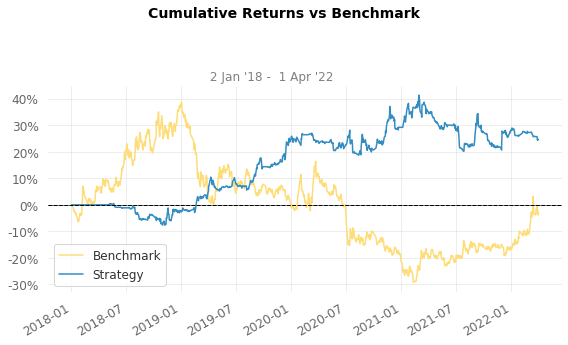

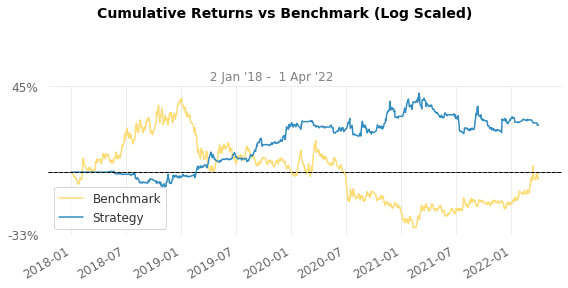

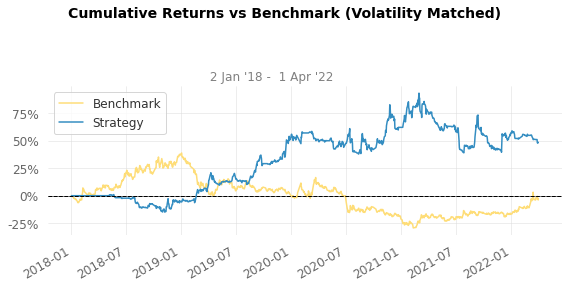

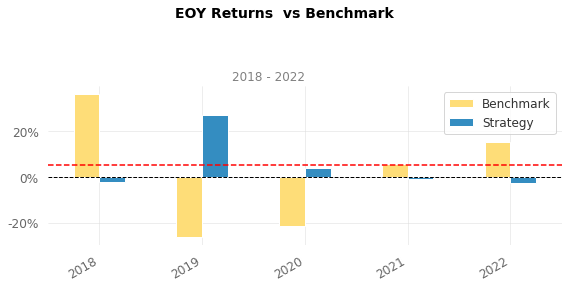

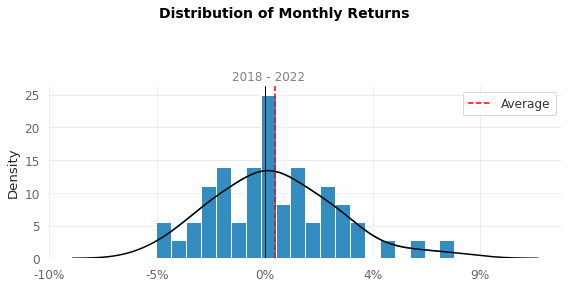

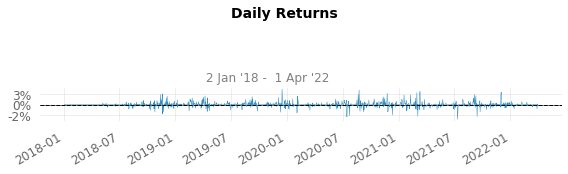

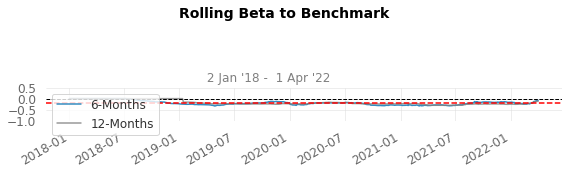

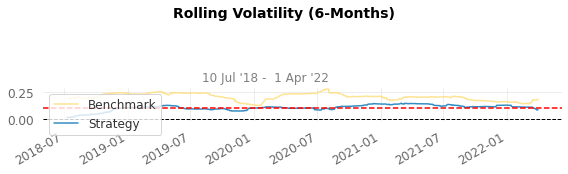

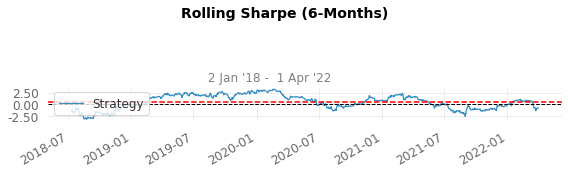

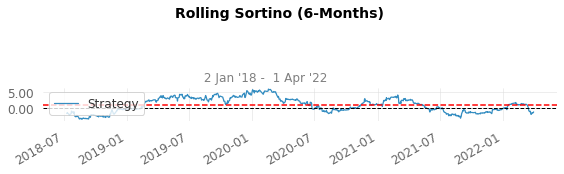

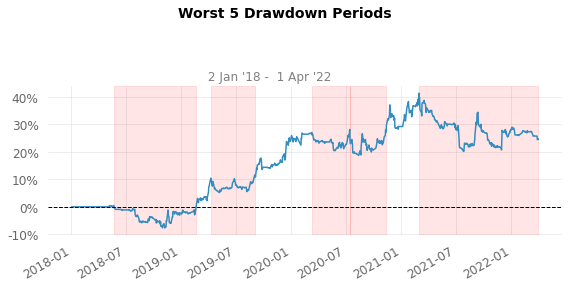

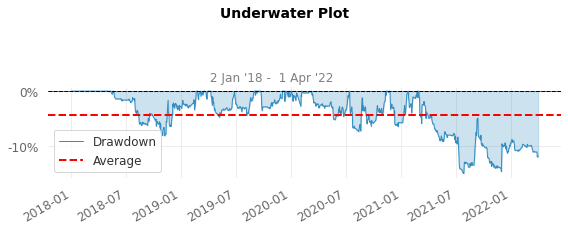

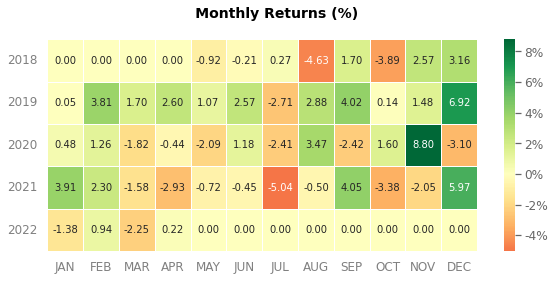

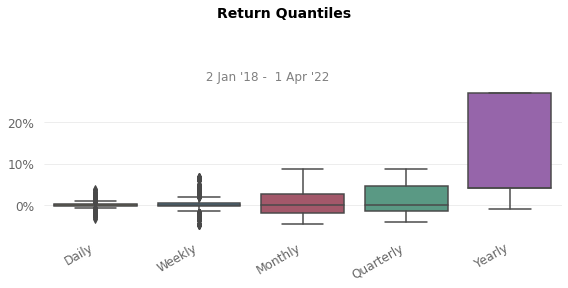

In [113]:
import akshare as ak

idx_data = ak.index_zh_a_hist(symbol='000300', period="daily", start_date='20180101', end_date='20220410')    
idx_data.rename(columns={'日期':'date', '开盘':'open', '收盘':'close', 
                           '最高':'high', '最低':'low', '成交量':'volume',
                           '成交额':'amount', '振幅':'swing', '涨跌幅':'chg_pct',
                           '涨跌额':'chg_amount', '换手率':'turnover',
                          }, inplace = True)
idx_data['date'] = pd.to_datetime(idx_data['date'], format='%Y-%m-%d')
bench=idx_data.set_index('date')
backtest.analysis(returns,bench)

In [26]:
nan = float("nan")
print(nan == nan)
print([nan] == [nan])

False
True
